This analysis is borrowed from RitvikMath nad Sia-Mak
- https://www.youtube.com/watch?v=JCKMV0Cuk0k&list=PLvcbYUQ5t0UHOLnBzl46_Q6QKtFgfMGc3&index=23
- https://github.com/sia-mak/Time-Series/blob/main/AR%20Model.ipynb

In [37]:
import pandas as pd
import numpy as np
import pylab
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
register_matplotlib_converters()
from time import time

In [31]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [32]:
#read data
production_ice_cream = pd.read_csv('ice_cream.csv', parse_dates=[0], index_col=0, date_parser=parser, squeeze=True)

In [33]:
#infer the frequency of the data
production_ice_cream = production_ice_cream.asfreq(pd.infer_freq(production_ice_cream.index))

In [34]:
production_ice_cream

DATE
1972-01-01     59.9622
1972-02-01     67.0605
1972-03-01     74.2350
1972-04-01     78.1120
1972-05-01     84.7636
                ...   
2019-09-01    100.1741
2019-10-01     90.1684
2019-11-01     79.7223
2019-12-01     75.7094
2020-01-01     83.6290
Freq: MS, Name: IPN31152N, Length: 577, dtype: float64

In [35]:
start_date = pd.to_datetime('2010-01-01')
production_ice_cream = production_ice_cream[start_date:]

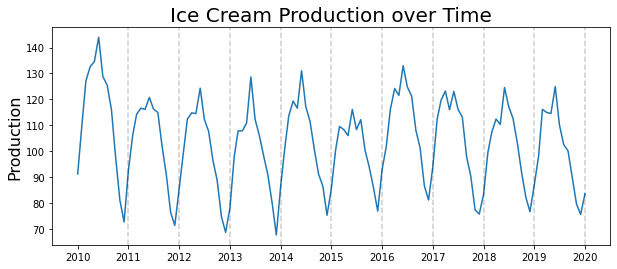

In [38]:
pylab.figure(figsize=(10,4))
pylab.plot(production_ice_cream)
pylab.title('Ice Cream Production over Time', fontsize=20)
pylab.ylabel('Production', fontsize=16)
for year in range(2011, 2021):
    pylab.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

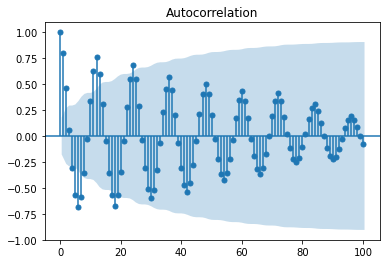

In [39]:
acf_plot = plot_acf(production_ice_cream, lags=100)

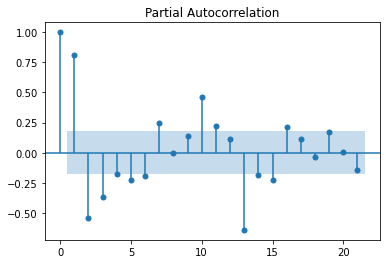

In [40]:
pacf_plot = plot_pacf(production_ice_cream)

In [41]:
train_end = datetime(2018, 12, 1)
test_end = datetime(2019, 12, 1)

train_data = production_ice_cream[:train_end]
test_data = production_ice_cream[train_end + timedelta(days=1):test_end]

In [52]:
# define model
model = ARIMA(train_data, order=(7, 0,0))

In [53]:
#fit the model
model_fit = model.fit()

In [54]:
#summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              IPN31152N   No. Observations:                  108
Model:                 ARIMA(7, 0, 0)   Log Likelihood                -361.526
Date:                Tue, 12 Jan 2021   AIC                            741.051
Time:                        20:31:10   BIC                            765.191
Sample:                    01-01-2010   HQIC                           750.839
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        103.6216      1.339     77.406      0.000     100.998     106.245
ar.L1          0.9497      0.097      9.837      0.000       0.760       1.139
ar.L2         -0.0964      0.131     -0.735      0.4

The AR(3) model is:

$\hat{y_t} = 103.62 + 0.95y_{t - 1} - 0.05*y_{t - 2} -0.40*y_{t - 3}$

Note that the $y_{t -2}$ coefficient is not significantly different from 0, so we could drop it from our predictions

In [46]:
#get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [47]:
#get the predictions and residuals
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

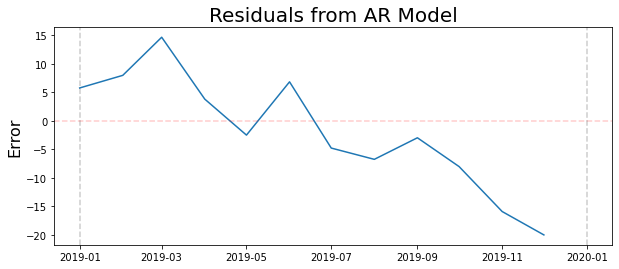

In [48]:
pylab.figure(figsize=(10, 4))
pylab.plot(residuals)
pylab.title('Residuals from AR Model', fontsize=20)
pylab.ylabel('Error', fontsize=16)
pylab.axhline(0, color='r', linestyle='--', alpha=0.2)
for year in range(2019,2021):
    pylab.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

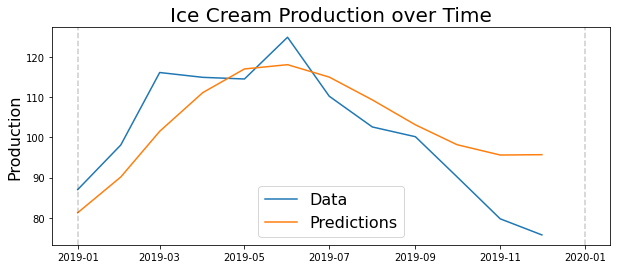

In [49]:
pylab.figure(figsize=(10,4))

pylab.plot(test_data)
pylab.plot(predictions)

pylab.legend(('Data', 'Predictions'), fontsize=16)

pylab.title('Ice Cream Production over Time', fontsize=20)
pylab.ylabel('Production', fontsize=16)
for year in range(2019,2021):
    pylab.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [50]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))

Mean Absolute Percent Error: 0.0895


In [51]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 9.884158747519644


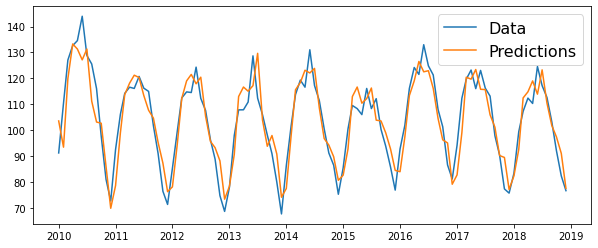

In [55]:
pylab.figure(figsize=(10,4))

pylab.plot(train_data)
pylab.plot(model_fit.predict(start=train_data.index[0], end=train_data.index[-1]))

pylab.legend(('Data', 'Predictions'), fontsize=16)